**Project 1: Analyzing IMDB Movie Reviews for Their Sentiment, Making a Model**

The goal for this project is to take IMDB reviews, and perform a sentiment analysis of them. Then if possible, use the reviews to predict possible ratings given by the user who wrote the review. The data being used originally came from a user on the Kaggle website, which I usuing after trimming out unneccessary columns of data like time of the review, and generes to make the data less cumbersome for only looking at each movie's text review. As the project progresses, I can untrim movie ratings to try and utilize them with the project for validating predictions of movie ratings, if possible.
 
So far the main input being used is going to be each review in the review column in the .csv which has been trimmed up a little in the code.
 
With the goal of getting a sentiment analysis out of this, I am attempting to get the simplified text data to vectorize for further proccessing of the text. The exact output I plan to get will be two columns with each review's sentiment score as an integer and the second will say if it is positive or negative with a string or boolean. Which I may be able to use to further train a model for predicting possible ratings left by those reviewers.

**The Dataset**

IMBD Movie Rating (2022)
Original URL: https://www.kaggle.com/datasets/youssefamdouni/imbd-movie-rating

The dataset includes columns for: Title, Rating, Gender/Genre, Movie ID, and the review

35,485 entries by default, Trimmed .csv used has 20,000


**Training a Model to Calculate Sentiment**

Will be attempting to use tokenize and refine those tokens for a goal of better efficiency, and then perform sentiment analysis on the data using the tools TextBlob and Vader tools. Currently am investigating the different sentiment values each provides, and seeing why they might be different.
My data does not have sentiment values to start from, so I will either dig deeper into the differences in the sentimence tools to make an informed decision, or push forwards into making a validation set, and continuing with making a trained model.


**Training With ML Model and DL Model**

Will attempt to filter out stop words, lemmatize, get training data, and run models.

In [1]:
# import all of the python modules/packages you'll need here
import pandas as pd
import re
import nltk
from textblob import TextBlob
#from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize
#from nltk.stem import PorterStemmer
#from nltk.stem import WordNetLemmatizer

#from argparse import Namespace
#from collections import Counter
#from nltk.corpus import stopwords
import json
import os
import re
import string

import numpy as np
import torch
#import torch.nn as nn
#import torch.nn.functional as F
#import torch.optim as optim
#from torch.utils.data import Dataset, DataLoader
import matplotlib
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
nltk.download('stopwords')
#stop=set(stopwords.words('english'))
# ...



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


True

Here is where I got started and was looking at the data I am working with. A couple graphs were used and tuned to get a goot cut off for the data compared to the full dataset.

In [2]:
df = pd.read_csv('/kaggle/input/imdb-ratings-3/IMDB_ratings3.csv')

print(df.head())
print (df.info())

#Make text_length hold the word count for each review
df['text_length'] = df['Review'].apply(len)
print(df['text_length'].describe())
print(df['Review'].head())
'''
# Create a bar graph of review lengths
plt.figure(figsize=(10, 6))
sorted_df = df.sort_values(by='text_length', ascending=False)
plt.bar(range(len(sorted_df)), sorted_df['text_length'], align='center')
plt.xlabel('Review Index')
plt.ylabel('Review Word Length')
plt.title('Review Word Length Distribution')
plt.show()
print('This graph shows that just of 10,000 reviews(half) are between 1,000 and 9,000 words long')

#Data Exploration ideas from https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

df['Review'].str.len().hist()

print('This shows that 20% of the data contain reviews with between 1,000 and 14,000 characters in them')
'''
# Define a function to calculate text length
def calculate_text_length(text):
    words = re.findall(r'\w+', text)
    return len(words)


   Entry     Title  Global_Rating                    Gender   ID_Movie  \
0      0  The Menu            7.2  Comedy  Horror  Thriller  tt9764362   
1      1  The Menu            7.2  Comedy  Horror  Thriller  tt9764362   
2      2  The Menu            7.2  Comedy  Horror  Thriller  tt9764362   
3      3  The Menu            7.2  Comedy  Horror  Thriller  tt9764362   
4      4  The Menu            7.2  Comedy  Horror  Thriller  tt9764362   

                                              Review  
0  This is a movie that plays on something everyo...  
1  The hype for The Menu intrigued me. The review...  
2  This film was something else, I am genuinely s...  
3  Nice try, but the satire doesn't land in this ...  
4  "The Menu" offers a trailer spectacular enough...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Entry          20000 non

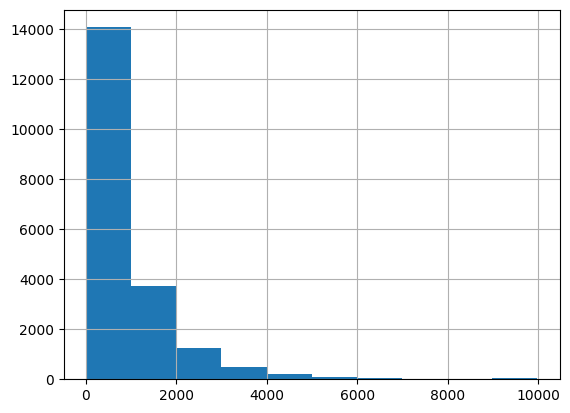The Vocabulary

Here is where the tokenization and use of TextBlob and Vader is. The tokens are then sorted and tags are assigned respective to their sentiment scores. TextBlob having a threshold of 0, and Vader with +/-.05

In [3]:
print(df.shape)

df['Review'][:5].str.split()

#df['tokens']=df['Review'].str.lower().str.split()

from nltk.tokenize import TweetTokenizer
tk = TweetTokenizer()
df['tokens_raw'] = df['Review'].apply(lambda x: tk.tokenize(x.lower()))
df.head()

import re
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))
chars2remove = set(['.','!','/', '?'])
df['tokens'] = df['tokens_raw'].apply(lambda x: [w for w in x if w not in stops])
df['tokens'] = df['tokens_raw'].apply(lambda x: [w for w in x if w not in chars2remove])
df['tokens'] = df['tokens_raw'].apply(lambda x: [w for w in x if not re.match('^#', w)]) # remove hashtags
#df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if not re.match('^http', w)]) # remove web links
#df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if not re.match('^@', w)]) # remove web links

df.head()

#from nltk.stem import WordNetLemmatizer
#from nltk.corpus import gutenberg
# also need to run following one time on your system (can be done outside of this notebook)
import nltk
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download()
#lemmatizer = WordNetLemmatizer()
#df['tokens'] = df['tokens_raw'].apply(lambda x: [lemmatizer.lemmatize(w, pos="v") for w in x])
#df['tokens'] = df['tokens_raw'].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
df.head()



(20000, 7)


,Entry,Title,Global_Rating,Gender,ID_Movie,Review,text_length,tokens_raw,tokens
0,0,The Menu,7.2,Comedy Horror Thriller,tt9764362,This is a movie that plays on something everyo...,3258,"[this, is, a, movie, that, plays, on, somethin...","[this, is, a, movie, that, plays, on, somethin..."
1,1,The Menu,7.2,Comedy Horror Thriller,tt9764362,The hype for The Menu intrigued me. The review...,985,"[the, hype, for, the, menu, intrigued, me, ., ...","[the, hype, for, the, menu, intrigued, me, ., ..."
2,2,The Menu,7.2,Comedy Horror Thriller,tt9764362,"This film was something else, I am genuinely s...",1682,"[this, film, was, something, else, ,, i, am, g...","[this, film, was, something, else, ,, i, am, g..."
3,3,The Menu,7.2,Comedy Horror Thriller,tt9764362,"Nice try, but the satire doesn't land in this ...",692,"[nice, try, ,, but, the, satire, doesn't, land...","[nice, try, ,, but, the, satire, doesn't, land..."
4,4,The Menu,7.2,Comedy Horror Thriller,tt9764362,"""The Menu"" offers a trailer spectacular enough...",971,"["", the, menu, "", offers, a, trailer, spectacu...","["", the, menu, "", offers, a, trailer, spectacu..."


In [4]:
threshold = 0
df['sentiment'] = df['Review'].apply(lambda review: TextBlob(review).sentiment.polarity)
df['tag'] = df['sentiment'].apply(lambda x: 'positive' if x > threshold else 'negative' if x < -threshold else 'neutral')
df.sentiment.value_counts(normalize=True)

sentiment
 0.000000    0.00990
 0.500000    0.00505
 0.250000    0.00345
 0.300000    0.00320
 0.200000    0.00225
              ...   
 0.122857    0.00005
 0.154950    0.00005
-0.048086    0.00005
 0.017143    0.00005
 0.275333    0.00005
Name: proportion, Length: 15389, dtype: float64

In [5]:
# before we do the prediction let's split the dataset into validation and training subsets
# (note that we could use sklearn.model_selection.train_test_split() for this, but we'll do it manually here)
import random
random.seed(42)

df_full = df.copy()
assert df_full.shape[0] == 20000

indices = list(range(df_full.shape[0]))

random.shuffle(indices)

train_indices = indices[:8500]
test_indices = indices[8500:]



#P.2
#stops = set(stopwords.words('english'))
#chars2remove = set(['.','!','/', '?'])
#
#lemmatizer = WordNetLemmatizer()
#df['tokens'] = df['tokens_raw'].apply(lambda x: [lemmatizer.lemmatize(w, pos="v") for w in x])



Performing Sentiment Analysis

In [6]:

'''
analyzer = SentimentIntensityAnalyzer()
df['vader_sentiment'] = df['Review'].apply(lambda review: analyzer.polarity_scores(review))
#df['vader_tag'] = df['vader_sentiment'].apply(lambda x: 'positive' if x > threshold else 'negative' if x < -threshold else 'neutral')
def analyze_sentiment(text, threshold_pos=0.05, threshold_neg=-0.05):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(text)
    compound_score = sentiment_scores['compound']
    
    if compound_score > threshold_pos:
        return 'positive'
    elif compound_score < threshold_neg:
        return 'negative'
    else:
        return 'neutral'

    

    
df['vader_tag'] = df['Review'].apply(analyze_sentiment)'''

# df will be the in-sample training dataset
df = df_full.iloc[train_indices,:].copy()
print(f"df.shape: {df.shape}")

# df_test will be the out-of-sample validation dataset
df_test = df_full.iloc[test_indices,:].copy()
print(f"df_test.shape: {df_test.shape}")
df_test.head()

df_pos = df[df['tag']=='positive']
df_neg = df[df['tag']=='negative']
df_neu = df[df['tag']=='neutral']



df.shape: (8500, 11)
df_test.shape: (11500, 11)


In [7]:
# subset the data by positive, negative, and neutral
#df_pos = df[df['tag'] == 'positive']
#df_neg = df[df['tag'] == 'negative']
#df_neu = df[df['tag'] == 'neutral']

def create_vocab_list(tokens_column):
    vocab = dict()
    for tweet_tokens in tokens_column:
        for token in tweet_tokens:
            if token not in vocab:
                vocab[token] = 1
            else:
                vocab[token] += 1
    return vocab

vocab_all = dict(sorted(create_vocab_list(df['tokens']).items(), key=lambda item: item[1], reverse=True))
vocab_pos = dict(sorted(create_vocab_list(df_pos['tokens']).items(), key=lambda item: item[1], reverse=True))
vocab_neg = dict(sorted(create_vocab_list(df_neg['tokens']).items(), key=lambda item: item[1], reverse=True))
vocab_neu = dict(sorted(create_vocab_list(df_neu['tokens']).items(), key=lambda item: item[1], reverse=True))
print(f"number of unique tokens overall: {len(vocab_all)}, pos tokens: {len(vocab_pos)}, neg: {len(vocab_neg)}, neu: {len(vocab_neu)}")

number of unique tokens overall: 53928, pos tokens: 49765, neg: 17118, neu: 760


In [8]:
list(vocab_all.items())[:20]

[('the', 78885),
 ('.', 64278),
 (',', 63239),
 ('and', 43108),
 ('a', 41157),
 ('to', 33434),
 ('of', 33364),
 ('is', 26690),
 ('in', 20916),
 ('it', 20418),
 ('i', 17471),
 ('this', 16983),
 ('that', 16617),
 ('with', 11860),
 ('was', 11774),
 ('but', 11698),
 ('movie', 11482),
 ('for', 10882),
 ('as', 10676),
 ('"', 10168)]

In [9]:
top_n_to_remove = 1000 #500 #500 #1000 # for our ad hoc model we can think of this as a type of hyperparameter
for i, item in enumerate(vocab_all.items()):
    if i == top_n_to_remove:
        break
    #print(f" removing token: {item[0]:15} (w/ freq = {item[1]:5}) from vocabs")
    if item[0] in vocab_pos:
        del vocab_pos[item[0]]
    if item[0] in vocab_neg:
        del vocab_neg[item[0]]
    if item[0] in vocab_neu:
        del vocab_neu[item[0]]

print(f"number of unique tokens overall: {len(vocab_all)}, pos tokens: {len(vocab_pos)}, neg: {len(vocab_neg)}, neu: {len(vocab_neu)}")

number of unique tokens overall: 53928, pos tokens: 48765, neg: 16118, neu: 400


In [10]:
top_n_to_remove = 1000 #500 #500 #1000 # for our ad hoc model we can think of this as a type of hyperparameter
for i, item in enumerate(vocab_all.items()):
    if i == top_n_to_remove:
        break
    #print(f" removing token: {item[0]:15} (w/ freq = {item[1]:5}) from vocabs")
    if item[0] in vocab_pos:
        del vocab_pos[item[0]]
    if item[0] in vocab_neg:
        del vocab_neg[item[0]]
    if item[0] in vocab_neu:
        del vocab_neu[item[0]]

print(f"number of unique tokens overall: {len(vocab_all)}, pos tokens: {len(vocab_pos)}, neg: {len(vocab_neg)}, neu: {len(vocab_neu)}")

number of unique tokens overall: 53928, pos tokens: 48765, neg: 16118, neu: 400


In [11]:
list(vocab_neg.items())[:10]

[('poorly', 60),
 ('crap', 60),
 ('badly', 58),
 ('wasted', 58),
 ('pointless', 55),
 ('fake', 50),
 ('failed', 50),
 ('n', 49),
 ('garbage', 44),
 ('disappointing', 43)]

In [12]:
# put positive, negative, neutral words together into a single object to create our 'model'
classifier_tokens = {"positive": list(vocab_pos.keys())[:], "negative": list(vocab_neg.keys())[:], "neutral": list(vocab_neu.keys())[:]}

# a sample review to classify
review2classify_i = 45
review2classify = df.iloc[review2classify_i,:]['tokens']
print(f"example of review to classify: \n  sentiment = {df.iloc[review2classify_i,10]} \n  review = {df.iloc[review2classify_i,5]}")

pos = 0
neg = 0
neu = 0
for tok in review2classify:
    if tok in classifier_tokens['positive']:
        pos += 1
    elif tok in classifier_tokens['negative']:
        neg += 1
    elif tok in classifier_tokens['neutral']:
        neu += 1

print(f"\n vocab counts: pos = {pos},  neg = {neg},  neu = {neu}")

example of review to classify: 
  sentiment = negative 
  review = Don't waste your money on this pathetic. .............Instead go and watch badhai ho badhai.

 vocab counts: pos = 5,  neg = 0,  neu = 0


In [13]:
def predict_review_sentiment(review_tokens):
    pos = 0
    neg = 0
    neu = 0
    for tok in review_tokens:
        if tok in classifier_tokens['positive']:
            pos += 1
        elif tok in classifier_tokens['negative']:
            neg += 1
        elif tok in classifier_tokens['neutral']:
            neu += 1
    if pos > neg and pos > neu:
        return "positive"
    elif neu > pos and neu > neg:
        return "neutral"
    else:
        return "negative"

In [14]:
#Split dataset into train and validation sets

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

our ad hoc model's accuracy on training dataset: 78.73%


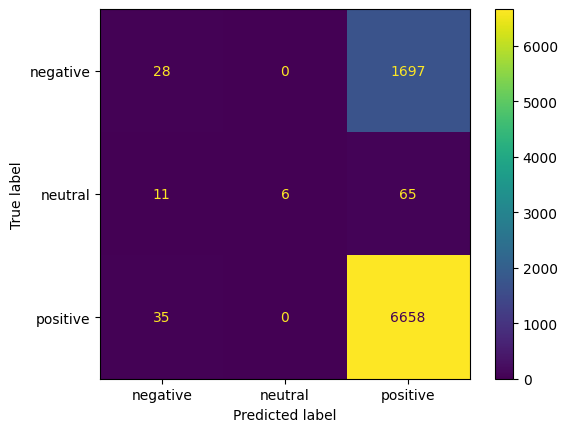

In [15]:
# make predictions for training dataset
df['predicted_sentiment'] = df['tokens'].apply(lambda x: predict_review_sentiment(x))

# check performance on training dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
disp = ConfusionMatrixDisplay(confusion_matrix(df['tag'], df['predicted_sentiment']), display_labels=['negative', 'neutral', 'positive'])
disp.plot()
mod_accuracy = accuracy_score(df['tag'], df['predicted_sentiment'])
print(f"our ad hoc model's accuracy on training dataset: {mod_accuracy*100:.2f}%")

**Not trying a "Real" ML Model**

In [16]:
if 'predicted_sentiment' in df.columns:
    print("removing column, predicted_sentiment, from df")
    df.drop('predicted_sentiment', axis=1, inplace=True)

if 'predicted_sentiment' in df_test.columns:
    print("removing column, predicted_sentiment, from df_test")
    df_test.drop('predicted_sentiment', axis=1, inplace=True)

print(f"df.shape: {df.shape}")
print(f"df_test.shape: {df_test.shape}")
df.head()

removing column, predicted_sentiment, from df
df.shape: (8500, 11)
df_test.shape: (11500, 11)


,Entry,Title,Global_Rating,Gender,ID_Movie,Review,text_length,tokens_raw,tokens,sentiment,tag
5117,5345,Skyscraper,5.8,Action Adventure Thriller,tt5758778,The villains in the predictable but entertaini...,6374,"[the, villains, in, the, predictable, but, ent...","[the, villains, in, the, predictable, but, ent...",0.068404,positive
6573,6862,Thunder Road,7.0,Comedy Drama,tt7738450,'Thunder Road' is a deftly presented tragicome...,231,"[', thunder, road, ', is, a, deftly, presented...","[', thunder, road, ', is, a, deftly, presented...",0.233333,positive
18851,19625,Yardie,5.8,Crime Drama,tt5862902,Dennis (Aml Ameen) watches his father (Everald...,527,"[dennis, (, aml, ameen, ), watches, his, fathe...","[dennis, (, aml, ameen, ), watches, his, fathe...",0.132407,positive
1201,1219,Terrifier 2,6.2,Horror,tt10403420,I usually give horror films allot of latitude ...,887,"[i, usually, give, horror, films, allot, of, l...","[i, usually, give, horror, films, allot, of, l...",0.109539,positive
13341,13901,Laila Majnu,7.7,Drama Romance,tt8011276,Being a millenial I never got a chance to watc...,510,"[being, a, millenial, i, never, got, a, chance...","[being, a, millenial, i, never, got, a, chance...",0.334091,positive


In [17]:
df['textclean'] = df['tokens'].apply(lambda x: ' '.join(x))
df.head()

,Entry,Title,Global_Rating,Gender,ID_Movie,Review,text_length,tokens_raw,tokens,sentiment,tag,textclean
5117,5345,Skyscraper,5.8,Action Adventure Thriller,tt5758778,The villains in the predictable but entertaini...,6374,"[the, villains, in, the, predictable, but, ent...","[the, villains, in, the, predictable, but, ent...",0.068404,positive,the villains in the predictable but entertaini...
6573,6862,Thunder Road,7.0,Comedy Drama,tt7738450,'Thunder Road' is a deftly presented tragicome...,231,"[', thunder, road, ', is, a, deftly, presented...","[', thunder, road, ', is, a, deftly, presented...",0.233333,positive,' thunder road ' is a deftly presented tragico...
18851,19625,Yardie,5.8,Crime Drama,tt5862902,Dennis (Aml Ameen) watches his father (Everald...,527,"[dennis, (, aml, ameen, ), watches, his, fathe...","[dennis, (, aml, ameen, ), watches, his, fathe...",0.132407,positive,dennis ( aml ameen ) watches his father ( ever...
1201,1219,Terrifier 2,6.2,Horror,tt10403420,I usually give horror films allot of latitude ...,887,"[i, usually, give, horror, films, allot, of, l...","[i, usually, give, horror, films, allot, of, l...",0.109539,positive,i usually give horror films allot of latitude ...
13341,13901,Laila Majnu,7.7,Drama Romance,tt8011276,Being a millenial I never got a chance to watc...,510,"[being, a, millenial, i, never, got, a, chance...","[being, a, millenial, i, never, got, a, chance...",0.334091,positive,being a millenial i never got a chance to watc...


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
#import seaborn as sns
tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(df['textclean']).toarray()
#X_train = tfidf_vectorizer.fit_transform(df['text']).toarray() # original tweet text (without our manual tokenization)

#from sklearn.feature_extraction.text import CountVectorizer
#one_hot_vectorizer = CountVectorizer(binary=True)
#tweet_matrix = one_hot_vectorizer.fit_transform(list(df['textclean']))#.toarray()

print(f"X_train.shape = {X_train.shape}")
type(X_train)

X_train.shape = (8500, 40192)


numpy.ndarray

In [19]:
X_train[:5, :10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [20]:
obs1 = list(X_train[0,:])
for i, tfidf_val in enumerate(obs1):
    if tfidf_val > 0:
        print(f"obs1 token at column i={i}, has a non-zero TF-IDF value: {tfidf_val}")

obs1 token at column i=231, has a non-zero TF-IDF value: 0.033202123694847
obs1 token at column i=232, has a non-zero TF-IDF value: 0.031056984612138367
obs1 token at column i=244, has a non-zero TF-IDF value: 0.03234676192111208
obs1 token at column i=246, has a non-zero TF-IDF value: 0.031056984612138367
obs1 token at column i=252, has a non-zero TF-IDF value: 0.0286840615668821
obs1 token at column i=254, has a non-zero TF-IDF value: 0.030093637233854324
obs1 token at column i=257, has a non-zero TF-IDF value: 0.027436640881814273
obs1 token at column i=267, has a non-zero TF-IDF value: 0.02813552233857568
obs1 token at column i=383, has a non-zero TF-IDF value: 0.03164788046435066
obs1 token at column i=581, has a non-zero TF-IDF value: 0.03585912004688705
obs1 token at column i=714, has a non-zero TF-IDF value: 0.024951875993278493
obs1 token at column i=732, has a non-zero TF-IDF value: 0.02666742285603574
obs1 token at column i=843, has a non-zero TF-IDF value: 0.027888130990766

In [21]:
obs1 = list(X_train[0,:])
for i, tfidf_val in enumerate(obs1):
    if tfidf_val > 0:
        print(f"obs1 has a non-zero TF-IDF value: {tfidf_val} at col i={i} (associated with token: {tfidf_vectorizer.get_feature_names_out()[i]})")

obs1 has a non-zero TF-IDF value: 0.033202123694847 at col i=231 (associated with token: 1954)
obs1 has a non-zero TF-IDF value: 0.031056984612138367 at col i=232 (associated with token: 1955)
obs1 has a non-zero TF-IDF value: 0.03234676192111208 at col i=244 (associated with token: 1967)
obs1 has a non-zero TF-IDF value: 0.031056984612138367 at col i=246 (associated with token: 1969)
obs1 has a non-zero TF-IDF value: 0.0286840615668821 at col i=252 (associated with token: 1974)
obs1 has a non-zero TF-IDF value: 0.030093637233854324 at col i=254 (associated with token: 1976)
obs1 has a non-zero TF-IDF value: 0.027436640881814273 at col i=257 (associated with token: 1979)
obs1 has a non-zero TF-IDF value: 0.02813552233857568 at col i=267 (associated with token: 1988)
obs1 has a non-zero TF-IDF value: 0.03164788046435066 at col i=383 (associated with token: 3000)
obs1 has a non-zero TF-IDF value: 0.03585912004688705 at col i=581 (associated with token: 96th)
obs1 has a non-zero TF-IDF va

In [22]:
df.iloc[0,:]

Entry                                                         5345
Title                                                   Skyscraper
Global_Rating                                                  5.8
Gender                                 Action  Adventure  Thriller
ID_Movie                                                 tt5758778
Review           The villains in the predictable but entertaini...
text_length                                                   6374
tokens_raw       [the, villains, in, the, predictable, but, ent...
tokens           [the, villains, in, the, predictable, but, ent...
sentiment                                                 0.068404
tag                                                       positive
textclean        the villains in the predictable but entertaini...
Name: 5117, dtype: object

In [23]:
#tag from sentiment
y_train = df.tag.to_numpy()
y_train[:10]

array(['positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive'],
      dtype=object)

In [24]:
for tag in classifier_tokens:
    print(f"top 10 tokens for {tag} tweets: \n {classifier_tokens[tag][:20]}")

top 10 tokens for positive tweets: 
 ['support', 'adult', 'delivers', 'connection', 'stand', 'german', 'clever', 'surprisingly', 'greatest', 'comic', 'word', 'portrayal', 'visuals', 'outstanding', 'compelling', 'indeed', 'festival', 'de', 'manages', 'recommended']
top 10 tokens for negative tweets: 
 ['poorly', 'crap', 'badly', 'wasted', 'pointless', 'fake', 'failed', 'n', 'garbage', 'disappointing', 'fails', 'flashbacks', 'painful', 'apparently', 'jump', 'lame', 'drug', 'total', '30', 'bland']
top 10 tokens for neutral tweets: 
 ['mmm', 'mmmm', '01100101', '00100000', 'mmmmm', 'que', 'mm', 'm', '👍', 'mmmmmmm', '01100001', 'es', 'una', 'y', 'entertained', 'cooking', 'xxxxxx', 'xxxx', 'mmmmmm', 'zero']


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

accuracy (on X_train): 1.0000


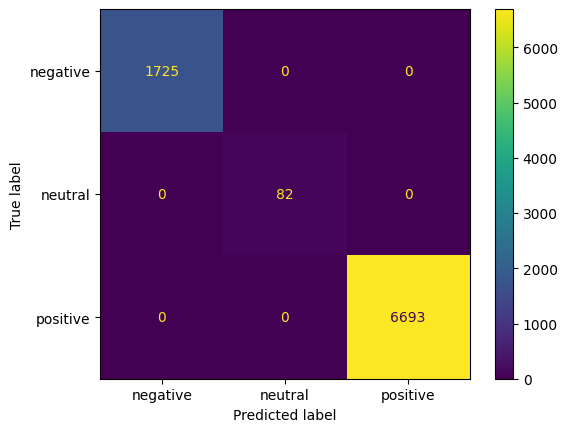

In [25]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=200)
model = model.fit(X_train, y_train)

predictions_train = model.predict(X_train)
predictions_train

disp = ConfusionMatrixDisplay(confusion_matrix(df['tag'], predictions_train), display_labels=['negative', 'neutral', 'positive'])
disp.plot()
print(f"accuracy (on X_train): {accuracy_score(df['tag'], predictions_train):.4f}")

In [26]:
df_test['textclean'] = df_test['tokens'].apply(lambda x: ' '.join(x))
X_test = tfidf_vectorizer.transform(df_test['textclean']).toarray()
X_test.shape

(11500, 40192)

In [27]:
print(df_test.columns)


Index(['Entry', 'Title', 'Global_Rating', 'Gender', 'ID_Movie', 'Review',
       'text_length', 'tokens_raw', 'tokens', 'sentiment', 'tag', 'textclean'],
      dtype='object')


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

accuracy (on X_test): 0.8098


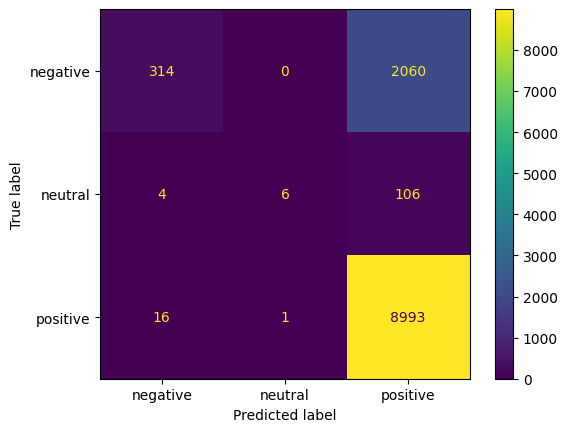

In [28]:
predictions_test = model.predict(X_test)
disp = ConfusionMatrixDisplay(confusion_matrix(df_test['tag'], predictions_test), display_labels=['negative', 'neutral', 'positive'])
disp.plot()
print(f"accuracy (on X_test): {accuracy_score(df_test['tag'], predictions_test):.4f}")

In [29]:
from sklearn.metrics import log_loss

# A function to create and fit a RF with a specific number of trees
def fitRFModel(hyperparam_value):
    rf_model = RandomForestClassifier(n_estimators=hyperparam_value, random_state=5)
    #rf_model = RandomForestClassifier(min_samples_split=hyperparam_value, random_state=1)
    rf_model.fit(X_train, y_train)
    y_train_pred_prob = rf_model.predict_proba(X_train)
    y_train_pred = rf_model.predict(X_train)
    y_val_pred_prob = rf_model.predict_proba(X_test)
    y_val_pred = rf_model.predict(X_test)
    train_loss = log_loss(df['tag'], y_train_pred_prob, labels=['negative', 'neutral', 'positive']) #, F.binary_cross_entropy(torch.tensor(y_train_pred), torch.tensor(y_train.to_numpy().astype(float)), reduction="mean")
    train_acc = accuracy_score(df['tag'], y_train_pred)
    val_loss = log_loss(df_test['tag'], y_val_pred_prob, labels=['negative', 'neutral', 'positive']) #F.binary_cross_entropy(torch.tensor(y_val_pred), torch.tensor(y_val.to_numpy().astype(float)), reduction="mean")
    val_acc = accuracy_score(df_test['tag'], y_val_pred)
    #return((train_loss.item(), val_loss.item()))
    return (train_loss, val_loss, train_acc, val_acc)

# Possible values of min_samples_split are 10 to 70 (by 5)
hyp_param_vals = list(range(5,151,10))
#hyp_param_vals = [5] + list(range(10,201,10))
metrics = []
for hp in hyp_param_vals:
    metrics.append(fitRFModel(hp))

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

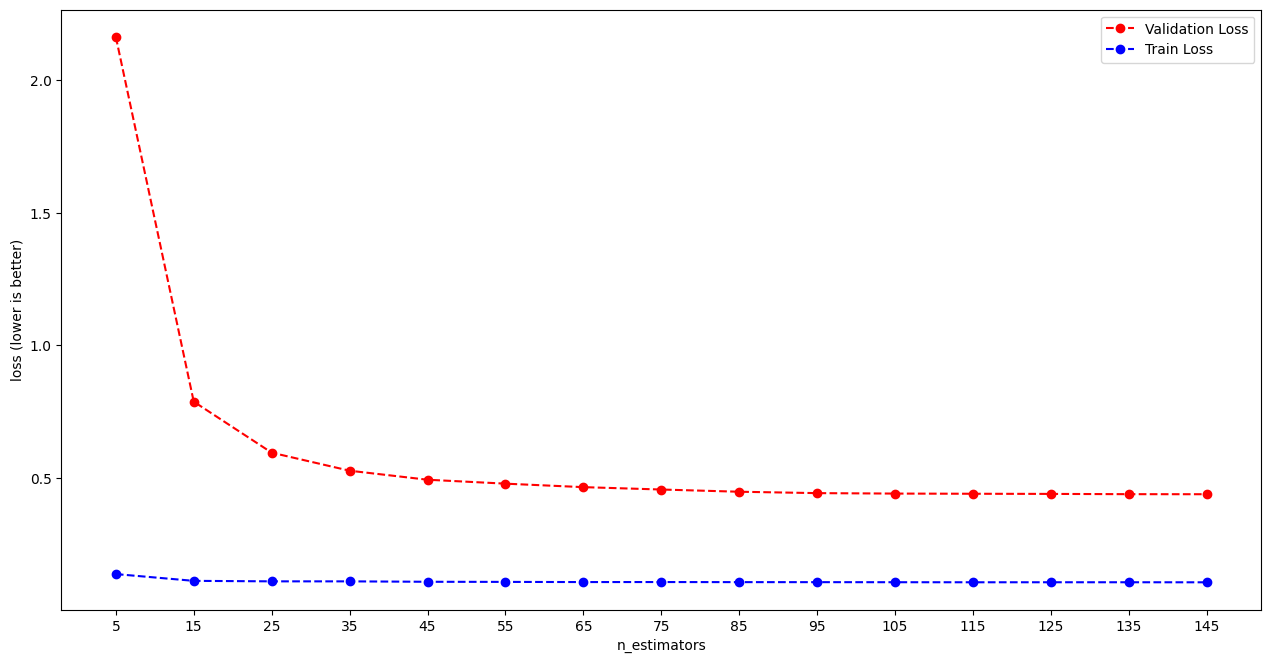

In [30]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes([0, 0, 1, 1]) #.1, 0.1, 0.8, 0.8]) # main axes
ax.plot(hyp_param_vals, [metric[1] for metric in metrics], '--ro') # validattion loss
ax.plot(hyp_param_vals, [metric[0] for metric in metrics], '--bo') # training loss
ax.legend(["Validation Loss", "Train Loss"], loc=1)
ax.set_xticks(hyp_param_vals)
ax.set(xlabel="n_estimators", ylabel="loss (lower is better)")
plt.show()

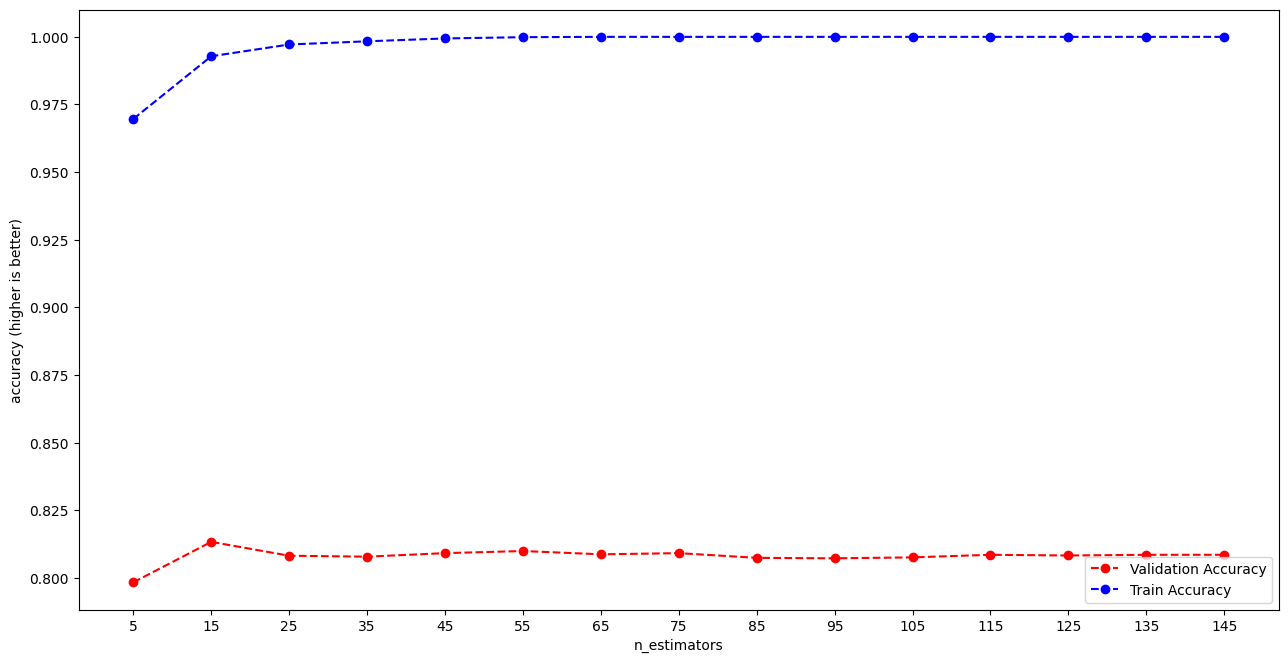

In [31]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes([0, 0, 1, 1]) #.1, 0.1, 0.8, 0.8]) # main axes
ax.plot(hyp_param_vals, [metric[3] for metric in metrics], '--ro') # validattion accuracy
ax.plot(hyp_param_vals, [metric[2] for metric in metrics], '--bo') # training accuracy
ax.legend(["Validation Accuracy", "Train Accuracy"], loc=4)
ax.set_xticks(hyp_param_vals)
ax.set(xlabel="n_estimators", ylabel="accuracy (higher is better)")
plt.show()

In [32]:
'''from sklearn.metrics import confusion_matrix
confusion_matrix(df['tag'], df['vader_tag'])'''

"from sklearn.metrics import confusion_matrix\nconfusion_matrix(df['tag'], df['vader_tag'])"

In [33]:
'''disp = ConfusionMatrixDisplay(confusion_matrix(df['tag'], df['vader_tag']), display_labels=['negative', 'neutral', 'positive'])
disp.plot()'''

"disp = ConfusionMatrixDisplay(confusion_matrix(df['tag'], df['vader_tag']), display_labels=['negative', 'neutral', 'positive'])\ndisp.plot()"

The accuracy of TextBlob's sentiment scores vs Vader's

In [34]:
'''mod_accuracy = accuracy_score(df['tag'], df['vader_tag'])
print(f"TextBlob vs Vader accuracy is: {mod_accuracy*100:.2f}%")'''

'mod_accuracy = accuracy_score(df[\'tag\'], df[\'vader_tag\'])\nprint(f"TextBlob vs Vader accuracy is: {mod_accuracy*100:.2f}%")'

Saved possible code for future part, but not in use

**Prep-work**

In [35]:
'''
def preprocess_text(text):
    #Set all text to lowercase
    text=text.lower()
    #Remove anything not a letter of the alphabet or a space, i.e, empty string replaces it
    text + re.sub(r'[^a-zA-Z\s]','', text)
    tokens = word_tokenize(text)
    #Remove stop words from tokens
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    return filtered_tokens
df['processed_text'] = df['Review'].apply(preprocess_text)

# Save the DataFrame with processed text back to a new CSV file
df.to_csv("preprocessed_sentiment_data.csv", index=False)
print(df['processed_text'].head())

# Get sentiment values from the tokenized reviews
#df['sentiment'] = df['processed_text'].apply(lambda review: TextBlob(review).sentiment)
df.sentiment.value_counts(normalize=True)
#df['processed_text'].dropna()
#df['sentiment'] = df['processed_text'].apply(lambda row: TextBlob(row['processed_text']).sentiment, axis=1)
#df['sentiment'] = df['processed_text'].sentiment

print(df['sentiment'].head())




args = Namespace(
    #Input data file(after pre-proccessing)
    input_data_path = '~/data/',
    review_csv = 'preprocessed_sentiment_data.csv',
    model_state_file = 'model.pth',
    #Output data and path info
    save_dir = '~/data/Project1/',
    vectorize_file = 'vectorizer.json',
    #Training parameters
    batch_size = 500,
    early_stopping_criteria = 3,
    learning_rate = 0.001,
    num_epochs = 6,
    seed = 42,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=False,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)
    '''

'\ndef preprocess_text(text):\n    #Set all text to lowercase\n    text=text.lower()\n    #Remove anything not a letter of the alphabet or a space, i.e, empty string replaces it\n    text + re.sub(r\'[^a-zA-Z\\s]\',\'\', text)\n    tokens = word_tokenize(text)\n    #Remove stop words from tokens\n    stop_words = set(stopwords.words(\'english\'))\n    filtered_tokens = [word for word in tokens if word not in stop_words]\n\n    return filtered_tokens\ndf[\'processed_text\'] = df[\'Review\'].apply(preprocess_text)\n\n# Save the DataFrame with processed text back to a new CSV file\ndf.to_csv("preprocessed_sentiment_data.csv", index=False)\nprint(df[\'processed_text\'].head())\n\n# Get sentiment values from the tokenized reviews\n#df[\'sentiment\'] = df[\'processed_text\'].apply(lambda review: TextBlob(review).sentiment)\ndf.sentiment.value_counts(normalize=True)\n#df[\'processed_text\'].dropna()\n#df[\'sentiment\'] = df[\'processed_text\'].apply(lambda row: TextBlob(row[\'processed_text\'

Initialization

In [36]:
'''
if args.reload_from_files:
    # training from a checkpoint
    print("Loading dataset and vectorizer")
    dataset = ReviewDataset.load_dataset_and_load_vectorizer(args.review_csv,
                                                            args.vectorizer_file)
else:
    print("Loading dataset and creating vectorizer")
    # create dataset and vectorizer
    dataset = ReviewDataset.load_dataset_and_make_vectorizer(args.review_csv)
    dataset.save_vectorizer(args.vectorizer_file)    
vectorizer = dataset.get_vectorizer()
'''

'\nif args.reload_from_files:\n    # training from a checkpoint\n    print("Loading dataset and vectorizer")\n    dataset = ReviewDataset.load_dataset_and_load_vectorizer(args.review_csv,\n                                                            args.vectorizer_file)\nelse:\n    print("Loading dataset and creating vectorizer")\n    # create dataset and vectorizer\n    dataset = ReviewDataset.load_dataset_and_make_vectorizer(args.review_csv)\n    dataset.save_vectorizer(args.vectorizer_file)    \nvectorizer = dataset.get_vectorizer()\n'